In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder,LabelEncoder    
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

/home/edward/loan/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df=pd.read_csv('datasets/loan_aproval/loan_approval_dataset.csv')
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [3]:
#i will drop the id we don't need it
df=df.drop(columns='loan_id')
df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [4]:
#see the shape of the data we have 
df.shape

(4269, 12)

In [5]:
#lets see some information 
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0    no_of_dependents          4269 non-null   int64
 1    education                 4269 non-null   str  
 2    self_employed             4269 non-null   str  
 3    income_annum              4269 non-null   int64
 4    loan_amount               4269 non-null   int64
 5    loan_term                 4269 non-null   int64
 6    cibil_score               4269 non-null   int64
 7    residential_assets_value  4269 non-null   int64
 8    commercial_assets_value   4269 non-null   int64
 9    luxury_assets_value       4269 non-null   int64
 10   bank_asset_value          4269 non-null   int64
 11   loan_status               4269 non-null   str  
dtypes: int64(9), str(3)
memory usage: 400.3 KB


In [6]:
# we have 3 string columns and 10 int there is no null values 
#let's see desc of this data
df.describe()

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03
mean,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06
std,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06
min,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06
75%,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


1. First observation:

- The minimum value of residential_assets_value is less than zero, which is abnormal.
Asset value cannot be negative.
It could be zero (meaning the person owns nothing), but it should not be negative.
Therefore, I need to replace these values using mean or median, or delete the rows.

Z-score for the minimum value in the residential columns:

z=(min−mean)/std

	​



2. Second :
    - all the other columns have a logical min and max value 

# Now let's do some statistic:
   1. In the next cell, I will calculate the min and max z-score for every numeric column.
    The Z-score formula is: z score=(x-mean)/std


   This helps detect outliers.

Note:
If |z| < 3, the value is normal.
If |z| ≥ 3, it is an outlier.


   2. after that i will calculate the skew of the columns 

    Note:
      skew=0 normal
      skew>0 right
      skew<0 left 

      It is normal for financial data (like income and loan amounts) to be right-skewed.
Because most people have average income (e.g., 10k or 20k), while a small number of people may have very high income ( 100k or 1M).
Negative money or negative assets are not realistic, so the distribution tends to be slightly right-skewed.

In [7]:
z_min=[]
z_max=[]
skew=[]
num_columns=df.select_dtypes(include='number').columns
for col in num_columns:
    z_min.append(np.abs((df[col].min() - df[col].mean()) / df[col].std()))
    z_max.append(np.abs((df[col].max() - df[col].mean()) / df[col].std()))
    skew.append(df[col].skew())

stats_df = pd.DataFrame({
    "column": num_columns,
    "z_min": z_min,
    "z_max": z_max,
    "skew": skew
})

stats_df

,column,z_min,z_max,skew
0,no_of_dependents,1.473375,1.474894,-0.017971
1,income_annum,1.731172,1.724671,-0.012814
2,loan_amount,1.640258,2.694412,0.308724
3,loan_term,1.558969,1.593844,0.036359
4,cibil_score,1.739462,1.740203,-0.009039
5,residential_assets_value,1.164366,3.325429,0.978451
6,commercial_assets_value,1.133104,3.287071,0.957791
7,luxury_assets_value,1.628593,2.644370,0.322208
8,bank_asset_value,1.531203,2.991616,0.560725


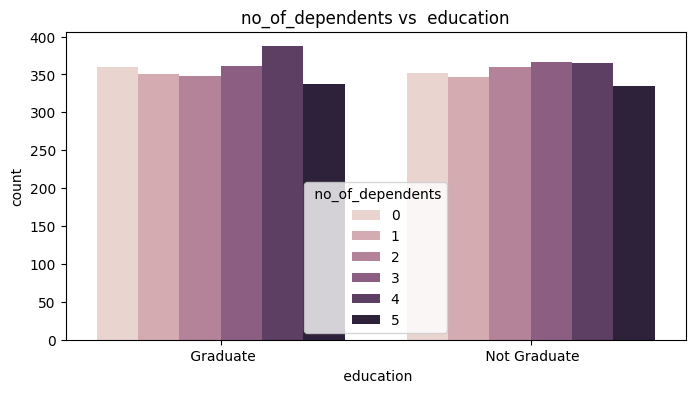

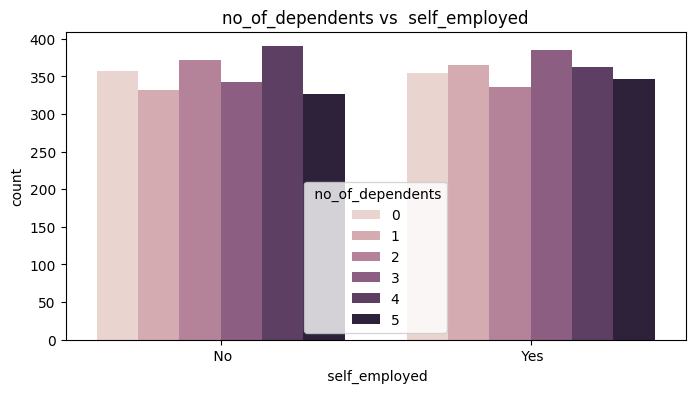

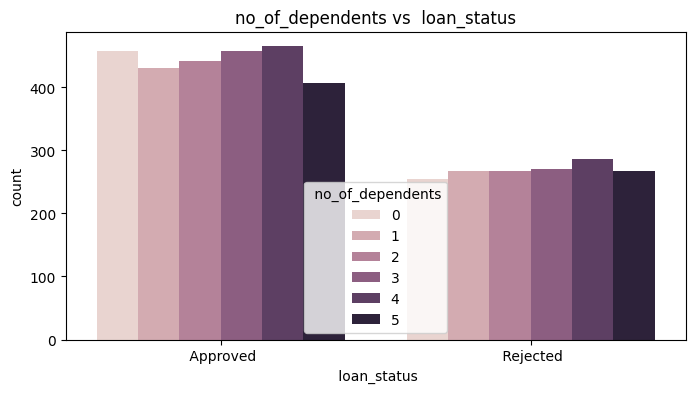

In [8]:

cat_cols = df.select_dtypes(exclude='number')

for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue=' no_of_dependents', data=df)
    plt.title(f"no_of_dependents vs {col}")
    plt.show()

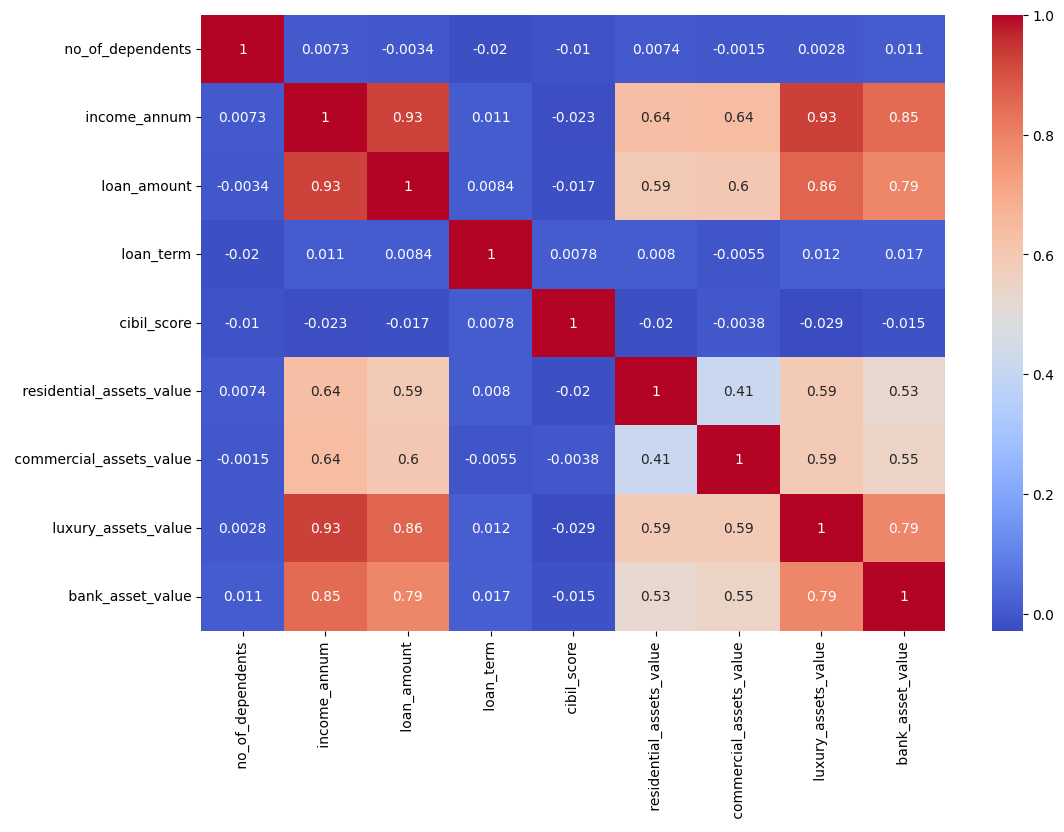

In [9]:
corr = df[num_columns].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

In [10]:
#let's split the data before do any thing
y=df[' loan_status']
x=df.drop(columns=' loan_status') 
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,shuffle=True)

In [11]:
#i will replace all the value under zero in the res column with nan then i will replace them with the median
imputer=SimpleImputer(strategy='median')

print(f"the number of value under zero before replace it with median is :\n{x[x[' residential_assets_value']<0].shape[0]}")


x_train[' residential_assets_value']=x_train[' residential_assets_value'].mask(x[' residential_assets_value']<0,np.nan)
x_train[' residential_assets_value']=imputer.fit_transform(x_train[[' residential_assets_value']])

x_test[' residential_assets_value']=imputer.transform(x_test[[' residential_assets_value']])

print(f"the number of value under zero after replace it with median is :\n{x_train[x_train[' residential_assets_value']<0].shape[0]}")

the number of value under zero before replace it with median is :
28
the number of value under zero after replace it with median is :
0


In [12]:


Labelen_target = LabelEncoder()
Labelen_self = LabelEncoder()
oneen = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# education
edu_train = oneen.fit_transform(x_train[[' education']])
edu_test = oneen.transform(x_test[[' education']])

edu_train = pd.DataFrame(edu_train, columns=oneen.get_feature_names_out([' education']))
edu_test = pd.DataFrame(edu_test, columns=oneen.get_feature_names_out([' education']))

x_train = x_train.drop(columns=[' education']).reset_index(drop=True)
x_test = x_test.drop(columns=[' education']).reset_index(drop=True)

x_train = pd.concat([x_train, edu_train], axis=1)
x_test = pd.concat([x_test, edu_test], axis=1)

# self_employed
x_train[' self_employed'] = Labelen_self.fit_transform(x_train[' self_employed'])
x_test[' self_employed'] = Labelen_self.transform(x_test[' self_employed'])

# target
y_train = Labelen_target.fit_transform(y_train)
y_test = Labelen_target.transform(y_test)


In [13]:
rf=RandomForestClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    
}
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,              
    scoring='accuracy',   
    n_jobs=-1,            
    verbose=2
)

grid.fit(x_train, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[CV] END .......................max_depth=5, n_estimators=50; total time=   0.4s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.5s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.4s
[CV] END ......................max_depth=5, n_estimators=100; total time=   0.8s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.7s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.7s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END ...................

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [5, 10, ...], 'n_estimators': [50, 100, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed

In [14]:
print("Best Score:", grid.best_score_)
print("Best Params:", grid.best_params_)


Best Score: 0.9774524158125916
Best Params: {'max_depth': 20, 'n_estimators': 100}


In [15]:
best_model = grid.best_estimator_
y_pred = best_model.predict(x_test)


In [16]:
report=classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       536
           1       0.98      0.97      0.97       318

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



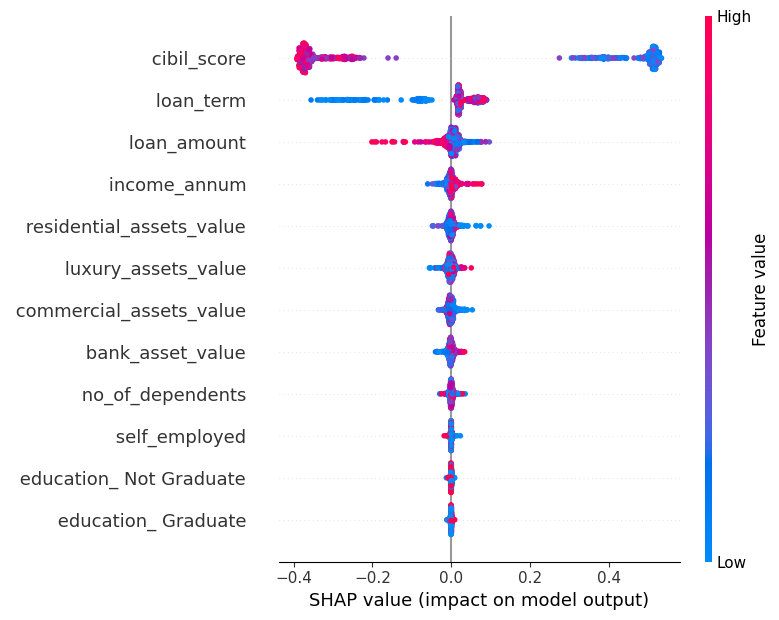

In [17]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(x_test)


shap_values_class1 = shap_values[:, :, 1]

shap.summary_plot(shap_values_class1, x_test)
#this the shap value that effect on accept

In [18]:
#now let's be more advanced we will use pipline to do every step then save the model

In [20]:
X = df.drop(columns=[' loan_status'])   
y = df[' loan_status']                 

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
num_cols = x_train.select_dtypes(include='number').columns
cat_cols =x_train.select_dtypes(exclude='number').columns



num_transformer = SimpleImputer(strategy='median')



cat_transformer = Pipeline([

    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])


param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(x_train, y_train)
print("Best Score:", grid.best_score_)
print("Best Params:", grid.best_params_)


joblib.dump(grid.best_estimator_, "pipeline_model.pkl")


Best Score: 0.9789165446559297
Best Params: {'model__max_depth': 20, 'model__min_samples_split': 5, 'model__n_estimators': 200}


['pipeline_model.pkl']

In [ ]:
x_train

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
1224,0,Graduate,Yes,9800000,23900000,14,459,1000000,13400000,21100000,7200000
478,3,Not Graduate,Yes,3600000,8600000,8,790,5400000,5900000,9800000,5200000
3065,2,Not Graduate,No,2000000,4000000,14,502,4900000,1500000,5400000,1300000
326,2,Not Graduate,Yes,3900000,11300000,12,516,3100000,0,10400000,4600000
2991,3,Not Graduate,No,2300000,8500000,12,557,3600000,1400000,6200000,1300000
...,...,...,...,...,...,...,...,...,...,...,...
23,0,Not Graduate,Yes,500000,1400000,2,551,900000,600000,1100000,300000
233,3,Not Graduate,Yes,8800000,34600000,8,386,14800000,16500000,18400000,6000000
3298,2,Not Graduate,Yes,6800000,15500000,12,338,9900000,1200000,21800000,8500000
1397,1,Not Graduate,Yes,9200000,24500000,4,545,25700000,0,20600000,13300000
